# Match Cutting
### Dataset exploration
We'll use some of the classes in the repo to read and analyze data.

In [66]:
import json
from typing import Set

import pandas as pd

from matchcut.data import Dataset

### Title set

In [122]:
df_titles = pd.read_csv('data/imdb-title-set.csv')
df_titles

,IMDB ID,title,genres,country,split
0,tt0050706,Mon Oncle (1958),Comedy,France,train
1,tt0059592,Pierrot le Fou (1965),"Crime, Drama, Romance",France,train
2,tt0061722,The Graduate (1967),"Comedy, Drama, Romance",USA,train
3,tt0061781,The Firemen's Ball (1967),"Comedy, Drama",Czechoslovakia,validation
4,tt0066921,A Clockwork Orange (1971),"Crime, Drama, Sci-Fi",UK,train
...,...,...,...,...,...
95,tt5827496,At Cafe 6 (2016),"Comedy, Romance",Taiwan,test
96,tt5866930,The Adventurers (2017),"Action, Adventure, Crime, Drama",China,validation
97,tt6157626,Legend of the Demon Cat (2017),"Drama, Fantasy, Horror, Mystery, Romance",China,validation
98,tt6298600,The Miracles of the Namiya General Store (2017),Drama,Japan,train


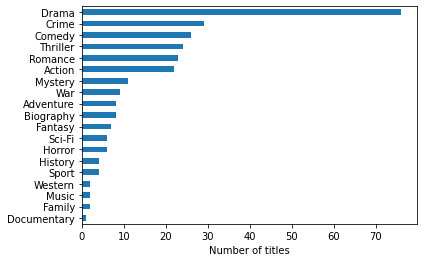

In [69]:
df_titles.genres.apply(lambda x: x.split(", ")).explode().value_counts()[::-1].plot(kind='barh')
_ = plt.xlabel("Number of titles")

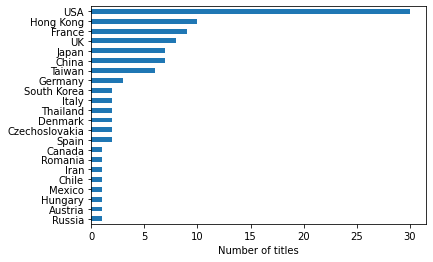

In [70]:
_ = df_titles.country.value_counts()[::-1].plot(kind='barh')
_ = plt.xlabel("Number of titles")

count     100.000000
mean     2002.800000
std        13.944334
min      1958.000000
25%      1996.500000
50%      2008.000000
75%      2013.000000
max      2017.000000
Name: 0, dtype: float64

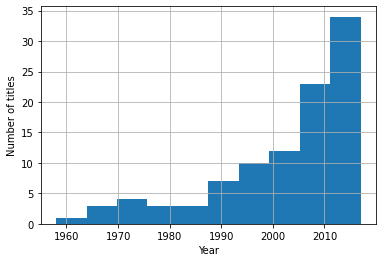

In [71]:
release_years = (
    df_titles
    .title
    .str.extract("\((\d+)\)")[0]
    .astype(int)
)
release_years.hist()
_ = plt.xlabel('Year')
_ = plt.ylabel("Number of titles")
release_years.describe()

### get all paired data for a task

In [55]:
def get_df(task: str, source: str = None) -> pd.DataFrame:
    """
    Read a dataframe where `task` is one of frame or motion.
    if `source` is not provided all the data is returned,
    if it is then the data is filtered down to the pairs
    retrieved by one of the 4 heuristics.
    """
    ds = Dataset(
        task=task,
        split="train",  # ignored
        encoder_name=None,
        agg_name=None,
        source=source,
    )
    return pd.DataFrame(p.__dict__ for p in ds.pairs_labeled_all)

#### convert to a dataframe

In [56]:
df_frame = get_df('frame')
df_motion = get_df('motion')
df_h1 = get_df('frame', 'heuristic 1: faces')
df_h2 = get_df('frame', 'heuristic 2: instance segmentation')
df_h3 = get_df('motion', 'heuristic 3: Farneback')
df_h4 = get_df('motion', 'heuristic 4: RAFT')

In [57]:
len(df_frame)

9985

In [58]:
len(df_motion)

9320

In [ ]:
len(get_unique_shots(df_frame))

In [62]:
def get_unique_shots(df):
    return set(x for _, r in df.iterrows() for x in ((r.imdb_id, r.shot1_idx), (r.imdb_id, r.shot2_idx)))

len(get_unique_shots(df_frame) | get_unique_shots(df_motion))

12993

In [72]:
df_motion.sample(5, random_state=0)

,imdb_id,shot1_idx,shot2_idx,label,source_info
1789,tt2267998,582,1738,False,SourceInfo(sources_and_scores=(('heuristic 3: ...
1817,tt2267998,935,1146,False,SourceInfo(sources_and_scores=(('heuristic 4: ...
2285,tt0178868,195,349,False,SourceInfo(sources_and_scores=(('heuristic 3: ...
2017,tt3672840,1160,1565,False,SourceInfo(sources_and_scores=(('heuristic 4: ...
6153,tt0427954,238,1856,False,SourceInfo(sources_and_scores=(('heuristic 4: ...


### Dataset statistics

In [81]:
def get_stats(df: pd.DataFrame, task: str):
    pairs = json.load(open(f"data/dataset-{task}.json"))
    pa_cnt = pd.Series(
        sum(pair["annotator_labels"].values()) in (0, 3)
        for pair in pairs
    ).sum()
    return {
        "Task": task,
        "Annotated pairs": len(df),
        "Positive pairs (majority label)": df.label.sum(),
        "Positive rate": df.label.mean(),
        "Perfect agreement pairs": pa_cnt,
        "Perfect agreement": pa_cnt / len(df),
    }

In [82]:
df_stats = pd.DataFrame([
    get_stats(df_frame, "frame"),
    get_stats(df_motion, "motion"),
])
df_stats = df_stats.set_index("Task").transpose().round(3)
df_stats = df_stats.assign(overall=df_stats.frame + df_stats.motion)
df_stats.loc['Positive rate', 'overall'] = df_stats.loc['Positive pairs (majority label)', 'overall'] / df_stats.loc['Annotated pairs', 'overall']
df_stats.loc['Perfect agreement', 'overall'] = df_stats.loc['Perfect agreement pairs', 'overall'] / df_stats.loc['Annotated pairs', 'overall']
df_stats

Task,frame,motion,overall
Annotated pairs,9985.000,9320.000,19305.000000
Positive pairs (majority label),867.000,927.000,1794.000000
Positive rate,0.087,0.099,0.092929
Perfect agreement pairs,8373.000,7027.000,15400.000000
Perfect agreement,0.839,0.754,0.797721


### heuristics

In [83]:
df_frame.label.mean()

0.08683024536805208

In [84]:
df_motion.label.mean()

0.09946351931330472

In [85]:
df_h1.label.mean()

0.0118

In [86]:
df_h2.label.mean()

0.1616

In [87]:
df_h3.label.mean()

0.1086

In [88]:
df_h4.label.mean()

0.0988

### title-level positive rate

In [89]:
def title_level_positive_rate(df: pd.DataFrame) -> pd.Series:
    return df.groupby('imdb_id').label.mean().describe()

In [90]:
title_level_positive_rate(df_frame)

count    100.000000
mean       0.086842
std        0.060670
min        0.000000
25%        0.040000
50%        0.070707
75%        0.120000
max        0.320000
Name: label, dtype: float64

In [91]:
title_level_positive_rate(df_motion)

count    100.000000
mean       0.100124
std        0.074155
min        0.000000
25%        0.043276
50%        0.081220
75%        0.147883
max        0.340659
Name: label, dtype: float64

#### by heuristic

In [92]:
title_level_positive_rate(df_h1)

count    100.000000
mean       0.011800
std        0.023285
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        0.120000
Name: label, dtype: float64

In [93]:
title_level_positive_rate(df_h2)

count    100.000000
mean       0.161600
std        0.113944
min        0.000000
25%        0.080000
50%        0.140000
75%        0.220000
max        0.580000
Name: label, dtype: float64

In [94]:
title_level_positive_rate(df_h3)

count    100.0000
mean       0.1086
std        0.0860
min        0.0000
25%        0.0400
50%        0.1000
75%        0.1400
max        0.3800
Name: label, dtype: float64

In [95]:
title_level_positive_rate(df_h4)

count    100.000000
mean       0.098800
std        0.088435
min        0.000000
25%        0.040000
50%        0.080000
75%        0.140000
max        0.380000
Name: label, dtype: float64

### shot time ranges

In [96]:
df_time_ranges = pd.read_csv('data/shot-time-ranges.csv')
df_time_ranges.head(3)

,imdb_id,shot_idx,start,end
0,tt0050706,0,0.000000,27.583333
1,tt0050706,6,123.541667,137.916667
2,tt0050706,7,137.916667,152.958333


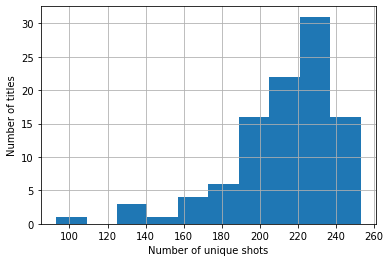

In [98]:
df_time_ranges.groupby('imdb_id').size().hist()
_ = plt.xlabel('Number of unique shots')
_ = plt.ylabel('Number of titles')

##### shot duration stats

In [99]:
df_time_ranges_duration = df_time_ranges.assign(duration=df_time_ranges.end - df_time_ranges.start)
df_time_ranges_duration = df_time_ranges_duration.merge(df_titles.rename(columns={"IMDB ID": "imdb_id"}))
df_time_ranges_duration.duration.describe()

count    21205.000000
mean         8.173633
std         15.135620
min          0.240000
25%          2.083333
50%          3.878875
75%          8.091416
max        384.500000
Name: duration, dtype: float64

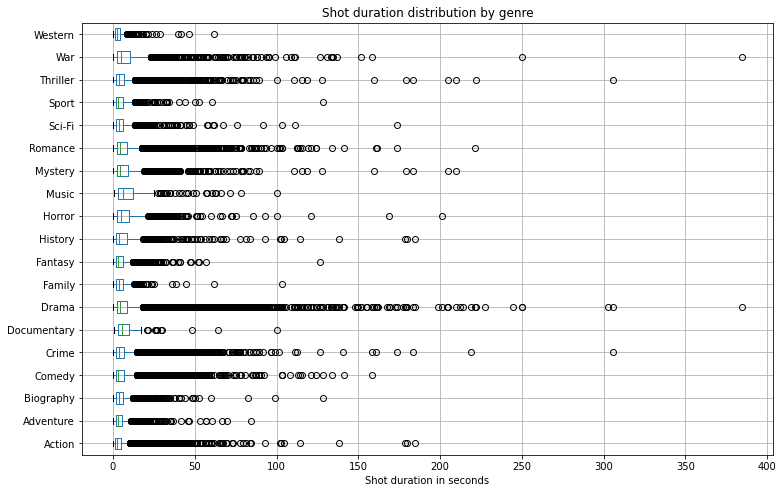

In [100]:
(
    df_time_ranges_duration
    .assign(genre=df_time_ranges_duration.genres.str.split(", ")).explode("genre")
    .boxplot(column="duration", by="genre", vert=False, figsize=(12, 8))
)
plt.title('Shot duration distribution by genre')
plt.suptitle('')
_ = plt.xlabel('Shot duration in seconds')

#### merge to get time ranges for pairs

In [101]:
def merge_time_ranges(df: pd.DataFrame, nbr: int) -> pd.DataFrame:
    """
    `df` to append time ranges (start and end time).
    `nbr` is either 1 or 2.
    """
    return df.merge(
        df_time_ranges.add_prefix(f"shot{nbr}_"),
        left_on=['imdb_id', f'shot{nbr}_idx'],
        right_on=[f'shot{nbr}_imdb_id', f'shot{nbr}_shot_idx'],
    ).drop(columns=[f'shot{nbr}_shot_idx', f'shot{nbr}_imdb_id'])


def add_time_ranges(df: pd.DataFrame) -> pd.DataFrame:
    return merge_time_ranges(merge_time_ranges(df, 1), 2)

In [102]:
add_time_ranges(df_motion)

,imdb_id,shot1_idx,shot2_idx,label,source_info,shot1_start,shot1_end,shot2_start,shot2_end
0,tt0118799,6,92,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,91.716623,103.019581,470.595112,476.225737
1,tt0118799,6,112,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,91.716623,103.019581,608.941650,613.988358
2,tt0118799,6,294,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,91.716623,103.019581,1502.959751,1506.546667
3,tt0118799,6,500,True,SourceInfo(sources_and_scores=(('heuristic 3: ...,91.716623,103.019581,2482.521641,2492.323099
4,tt0118799,6,530,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,91.716623,103.019581,2677.132719,2679.510094
...,...,...,...,...,...,...,...,...,...
9315,tt6788942,1089,1193,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,4961.250000,4965.250000,5320.583333,5321.333333
9316,tt6788942,1089,1380,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,4961.250000,4965.250000,5861.666667,5865.750000
9317,tt6788942,1203,1380,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,5337.458333,5341.750000,5861.666667,5865.750000
9318,tt6788942,1089,1426,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,4961.250000,4965.250000,6035.458333,6039.625000


### splits

In [103]:
def get_split_ids(split: str) -> Set[str]:
    return Dataset(split, "frame", None, None).imdb_ids

In [104]:
splits = ("train", "validation", "test")

In [105]:
split_ids = {s: get_split_ids(s) for s in splits}

In [106]:
split_ids.keys()

dict_keys(['train', 'validation', 'test'])

In [107]:
split_ids['test']

{'tt0081505',
 'tt0090257',
 'tt0092603',
 'tt0101700',
 'tt0108656',
 'tt0118799',
 'tt0118845',
 'tt0133093',
 'tt0208092',
 'tt0250494',
 'tt0266697',
 'tt0457430',
 'tt0940709',
 'tt0993846',
 'tt1602620',
 'tt2258281',
 'tt3508840',
 'tt3672840',
 'tt5580036',
 'tt5827496'}

#### filter by split

In [108]:
df_motion[df_motion.imdb_id.isin(split_ids['train'])]

,imdb_id,shot1_idx,shot2_idx,label,source_info
265,tt1560747,2,139,False,SourceInfo(sources_and_scores=(('heuristic 3: ...
266,tt1560747,2,166,False,SourceInfo(sources_and_scores=(('heuristic 3: ...
267,tt1560747,2,402,False,SourceInfo(sources_and_scores=(('heuristic 3: ...
268,tt1560747,49,54,False,SourceInfo(sources_and_scores=(('heuristic 4: ...
269,tt1560747,54,61,False,SourceInfo(sources_and_scores=(('heuristic 4: ...
...,...,...,...,...,...
9315,tt6788942,1203,1426,False,SourceInfo(sources_and_scores=(('heuristic 4: ...
9316,tt6788942,1206,1367,False,SourceInfo(sources_and_scores=(('heuristic 4: ...
9317,tt6788942,1367,1505,False,SourceInfo(sources_and_scores=(('heuristic 4: ...
9318,tt6788942,1367,1558,False,SourceInfo(sources_and_scores=(('heuristic 4: ...


#### append split to each row

In [109]:
id_to_split = {imdb_id: s for s, ids in split_ids.items() for imdb_id in ids}

In [110]:
df_motion.assign(split=df_motion.imdb_id.map(id_to_split))

,imdb_id,shot1_idx,shot2_idx,label,source_info,split
0,tt0118799,6,92,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,test
1,tt0118799,6,112,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,test
2,tt0118799,6,294,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,test
3,tt0118799,6,500,True,SourceInfo(sources_and_scores=(('heuristic 3: ...,test
4,tt0118799,6,530,False,SourceInfo(sources_and_scores=(('heuristic 3: ...,test
...,...,...,...,...,...,...
9315,tt6788942,1203,1426,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,train
9316,tt6788942,1206,1367,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,train
9317,tt6788942,1367,1505,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,train
9318,tt6788942,1367,1558,False,SourceInfo(sources_and_scores=(('heuristic 4: ...,train


### Annotator-level data

In [133]:
def get_annotator_level_labels(task: str) -> pd.DataFrame:
    pairs = json.load(open(f"data/dataset-{task}.json"))
    return pd.DataFrame(
        dict(
            imdb_id=pair['imdb_id'],
            shot1_idx=pair['clip1_index'],
            shot2_idx=pair['clip2_index'],
            annotator_idx=int(idx),
            annotator_label=label,
            task=task,
        )
        for pair in pairs
        for idx, label in pair["annotator_labels"].items()
    )

df_annotator_level = pd.concat((
    get_annotator_level_labels(task="frame"),
    get_annotator_level_labels(task="motion"),
))
df_annotator_level

,imdb_id,shot1_idx,shot2_idx,annotator_idx,annotator_label,task
0,tt0118799,3,13,1,False,frame
1,tt0118799,3,13,2,False,frame
2,tt0118799,3,13,3,False,frame
3,tt0118799,3,14,1,False,frame
4,tt0118799,3,14,2,False,frame
...,...,...,...,...,...,...
27955,tt6788942,1367,1558,2,False,motion
27956,tt6788942,1367,1558,3,False,motion
27957,tt6788942,1367,1721,1,False,motion
27958,tt6788942,1367,1721,2,False,motion


In [134]:
df_annotator_level.groupby('task').annotator_label.mean()

task
frame     0.104991
motion    0.131545
Name: annotator_label, dtype: float64

In [135]:
df_annotator_level.annotator_label.mean()

0.11781058447725114

### Annotator agreement

In [138]:
df_annotator_pos_cnt = (
    df_annotator_level
    .groupby(['task', 'imdb_id', 'shot1_idx', 'shot2_idx'])
    .annotator_label
    .sum()
    .apply(int)
    .rename('positive_label_cnt').reset_index()
)

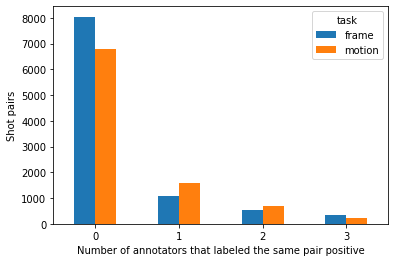

In [146]:
_ = df_annotator_pos_cnt.groupby(['positive_label_cnt', 'task']).size().unstack().plot(kind='bar', rot=0)
plt.ylabel('Shot pairs')
_ = plt.xlabel('Number of annotators that labeled the same pair positive')

### experiment results

#### experiment 1

In [167]:
df_exp1 = pd.read_csv('experiment1.csv')

#### detailed view

In [168]:
df_exp1

,task,encoder,model,agg,train-AP,validation-AP,test-AP
0,frame,baseline,NaN,NaN,0.079,0.094,0.119
1,motion,baseline,NaN,NaN,0.095,0.096,0.122
2,frame,heuristic 1,NaN,NaN,0.012,0.006,0.017
3,frame,heuristic 2,NaN,NaN,0.169,0.177,0.207
4,frame,heuristic 3,NaN,NaN,0.218,0.234,0.248
...,...,...,...,...,...,...,...
392,motion,yamnet-swin,mlp_small,concat,0.778 ± 0.018,0.12 ± 0.006,0.167
393,motion,yamnet-swin,mlp_small,abs_diff,0.773 ± 0.015,0.118 ± 0.008,0.132
394,motion,yamnet-swin,mlp_large,mean,0.793 ± 0.022,0.121 ± 0.008,0.182
395,motion,yamnet-swin,mlp_large,concat,0.778 ± 0.014,0.122 ± 0.004,0.176


#### aggregated

In [171]:
(
    df_exp1
    .assign(val_mean=df_exp1['validation-AP'].apply(lambda x: float(x.split(' ')[0])))
    .groupby(['task', 'encoder'])
    # take the combination with the highest mean validation AP per (task, encoder)
    .apply(lambda rows: rows.sort_values(by='val_mean', ascending=False).head(1))
    .drop(columns=['val_mean'])
    .reset_index(drop=True)
)

,task,encoder,model,agg,train-AP,validation-AP,test-AP
0,frame,baseline,NaN,NaN,0.079,0.094,0.119
1,frame,clip,mlp,mean,0.829 ± 0.011,0.253 ± 0.023,0.240
2,frame,clip4clip,mlp_large,mean,0.836 ± 0.009,0.277 ± 0.012,0.304
3,frame,efficientnetb7,xgboost,mean,0.852 ± 0.011,0.261 ± 0.025,0.352
4,frame,heuristic 1,NaN,NaN,0.012,0.006,0.017
5,frame,heuristic 2,NaN,NaN,0.169,0.177,0.207
6,frame,heuristic 3,NaN,NaN,0.218,0.234,0.248
7,frame,r2plus1d,mlp_large,mean,0.829 ± 0.012,0.222 ± 0.021,0.224
8,frame,resnet50,mlp_large,concat,0.838 ± 0.01,0.266 ± 0.015,0.269
9,frame,swin,mlp,mean,0.815 ± 0.014,0.27 ± 0.03,0.287


### experiment 2

In [156]:
pd.read_csv('experiment2.csv')

,task,encoder,model,agg,train-AP,validation-AP,test-AP
0,frame,clip4clip,NaN,NaN,0.751 ± 0.005,0.273 ± 0.01,0.359
1,frame,clip,NaN,NaN,0.743 ± 0.005,0.232 ± 0.009,0.320
2,frame,r2plus1d,NaN,NaN,0.768 ± 0.004,0.218 ± 0.007,0.263
3,frame,efficientnetb7,NaN,NaN,0.778 ± 0.004,0.284 ± 0.01,0.373
4,frame,resnet50,NaN,NaN,0.771 ± 0.006,0.258 ± 0.01,0.342
5,frame,swin,NaN,NaN,0.75 ± 0.004,0.255 ± 0.005,0.361
6,frame,yamnet,NaN,NaN,0.355 ± 0.016,0.118 ± 0.003,0.097
7,motion,r2plus1d,NaN,NaN,0.713 ± 0.007,0.173 ± 0.001,0.217
8,motion,swin,NaN,NaN,0.702 ± 0.006,0.143 ± 0.002,0.170
9,motion,clip4clip,NaN,NaN,0.704 ± 0.006,0.119 ± 0.001,0.144
